### TUTORIAL

In [1]:
import pandas as pd
import numpy as np
import csv
from sklearn.utils import Bunch
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from gensim.models import Word2Vec
import nltk
from gensim.models import KeyedVectors

from nltk.cluster import KMeansClusterer
from nltk.tokenize import word_tokenize
#nltk.download('punkt')
import numpy as np 

from sklearn import cluster
from sklearn import metrics

from tensorflow.keras.preprocessing.text import one_hot
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
categories = ["not_sexist", "sexist"]
#               2161           989

In [3]:
data = pd.read_csv("my_csv.csv",sep = ',')
data.columns = ['tweet', 'class']

X = data['tweet']
y = data['class']

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

### Tokenizing text with scikit-learn

In [4]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(2204, 11192)

In [5]:
count_vect.vocabulary_.get(u'femme')

4014

### From occurrences to frequencies

In [6]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(2204, 11192)

### Training a classifier

In [7]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [8]:
docs_new = ["Les hommes c'est tous les mêmes", 'Il est étudiant.'] #marche pas du tout
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
     print('%r => %s' % (doc, categories[category]))

"Les hommes c'est tous les mêmes" => not_sexist
'Il est étudiant.' => not_sexist


### Building a pipeline

In [9]:
text_clf = Pipeline([
...     ('vect', CountVectorizer()),
...     ('tfidf', TfidfTransformer()),
...     ('clf', MultinomialNB()),
... ])
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

### Evaluation of the performance on the test set

In [10]:
docs_test = X_test
predicted = text_clf.predict(docs_test)
np.mean(predicted == y_test)

0.6931216931216931

### SVM

In [11]:
text_clf = Pipeline([
...     ('vect', CountVectorizer()),
...     ('tfidf', TfidfTransformer()),
...     ('clf', SGDClassifier(loss='hinge', penalty='l2',
...                           alpha=1e-3, random_state=42,
...                           max_iter=5, tol=None)),
... ])
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(docs_test)
np.mean(predicted == y_test)

0.7544973544973544

In [12]:
print(metrics.classification_report(y_test, predicted,
...     target_names=categories))

              precision    recall  f1-score   support

  not_sexist       0.76      0.94      0.84       642
      sexist       0.74      0.36      0.48       303

    accuracy                           0.75       945
   macro avg       0.75      0.65      0.66       945
weighted avg       0.75      0.75      0.72       945



In [13]:
metrics.confusion_matrix(y_test, predicted)

array([[605,  37],
       [195, 108]], dtype=int64)

### Parameter tuning using grid search

In [14]:
parameters = {
...     'vect__ngram_range': [(1, 1), (1, 2)],
...     'tfidf__use_idf': (True, False),
...     'clf__alpha': (1e-2, 1e-3),
... }

In [15]:
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)

In [16]:
gs_clf = gs_clf.fit(X_train[:100], y_train[:100])
#ameliorer vecteur et algo et representation
#-> plus de poids sur les mots sexistes

In [17]:
example_1 = 'La femme'
example_2 = "L'homme"
example_3 = "La femme doit être dans la cuisine"

print(example_1 + "  => " + str(categories[gs_clf.predict([example_1])[0]]))
print(example_2 + "  => " + str(categories[gs_clf.predict([example_2])[0]]))
print(example_3 + "  => " + str(categories[gs_clf.predict([example_3])[0]]))

La femme  => not_sexist
L'homme  => not_sexist
La femme doit être dans la cuisine  => not_sexist


In [18]:
gs_clf.best_score_

0.74

In [19]:
for param_name in sorted(parameters.keys()):
     print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 0.01
tfidf__use_idf: True
vect__ngram_range: (1, 1)


### Oversampling

In [20]:
# instantiating the random over sampler 
ros = RandomOverSampler()
# resampling X, y
X_ros, y_ros = ros.fit_resample(np.array(X_train).reshape(-1,1), y_train)# new class distribution 
print(Counter(y_ros))

Counter({0: 1518, 1: 1518})


In [21]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_ros.ravel())
X_train_counts.shape

(3036, 11192)

In [22]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(3036, 11192)

In [23]:
clf = MultinomialNB().fit(X_train_tfidf, y_ros)
docs_new = ["y'a que les femmes qui pleurent", "C'est un homme."] 
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
     print('%r => %s' % (doc, categories[category]))
        
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB()),])
text_clf.fit(X_ros.ravel(), y_ros)


# resampling X, y
X_ros_test, y_ros_test = ros.fit_resample(np.array(X_test).reshape(-1,1), y_test)# new class distribution 
docs_test = X_ros_test.ravel()
predicted = text_clf.predict(docs_test)
np.mean(predicted == y_ros_test)
print("Accuracy : ", np.mean(predicted == y_ros_test))
metrics.confusion_matrix(y_ros_test, predicted)

"y'a que les femmes qui pleurent" => sexist
"C'est un homme." => sexist
Accuracy :  0.7710280373831776


array([[431, 211],
       [ 83, 559]], dtype=int64)

### Undersampling

In [24]:
# instantiating the random over sampler 
ros = RandomUnderSampler()
# resampling X, y
X_ros, y_ros = ros.fit_resample(np.array(X_train).reshape(-1,1), y_train)# new class distribution 
print(Counter(y_ros))

Counter({0: 686, 1: 686})


In [25]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_ros.ravel())
X_train_counts.shape

(1372, 8043)

In [26]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(1372, 8043)

In [27]:
clf = MultinomialNB().fit(X_train_tfidf, y_ros)
docs_new = ["y'a que les femmes qui pleurent", "C'est un homme."] 
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
     print('%r => %s' % (doc, categories[category]))
        
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB()),])
text_clf.fit(X_ros.ravel(), y_ros)


# resampling X, y
X_ros_test, y_ros_test = ros.fit_resample(np.array(X_test).reshape(-1,1), y_test)# new class distribution 
docs_test = X_ros_test.ravel()
predicted = text_clf.predict(docs_test)
print("Accuracy : ", np.mean(predicted == y_ros_test))
metrics.confusion_matrix(y_ros_test, predicted)


"y'a que les femmes qui pleurent" => sexist
"C'est un homme." => sexist
Accuracy :  0.7821782178217822


array([[203, 100],
       [ 32, 271]], dtype=int64)

### Oversampling and Undersampling

In [28]:
over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.8)

In [29]:
X_over, y_over = over.fit_resample(np.array(X_train).reshape(-1,1), y_train)
print(f"Oversampled: {Counter(y_over)}")

Oversampled: Counter({0: 1518, 1: 759})


In [30]:
# now to comine under sampling 
X_ros, y_ros = under.fit_resample(X_over, y_over)
print(f"Combined Random Sampling: {Counter(y_ros)}")

Combined Random Sampling: Counter({0: 948, 1: 759})


In [31]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_ros.ravel())
X_train_counts.shape

(1707, 8994)

In [32]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(1707, 8994)

In [33]:
clf = MultinomialNB().fit(X_train_tfidf, y_ros)
docs_new = ["y'a que les femmes qui pleurent", "C'est un homme."]
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
     print('%r => %s' % (doc, categories[category]))
        
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB()),])
text_clf.fit(X_ros.ravel(), y_ros)


# resampling X, y
X_ros_test, y_ros_test = ros.fit_resample(np.array(X_test).reshape(-1,1), y_test)# new class distribution 
docs_test = X_ros_test.ravel()
predicted = text_clf.predict(docs_test)
print("Accuracy : ", np.mean(predicted == y_ros_test))
metrics.confusion_matrix(y_ros_test, predicted)


"y'a que les femmes qui pleurent" => sexist
"C'est un homme." => sexist
Accuracy :  0.7194719471947195


array([[243,  60],
       [110, 193]], dtype=int64)

### Word Embedding using Doc2Vec

###### 1st Step : Getting cleaned data

In [34]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    

X = data['tweet']
y = data['class'] 

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

###### 2nd step : Keeping a tokenized version of the sentences and the corresponding categories

In [35]:
X_tokenized = []
y_tokenized = []

for sentence in X_train:
    X_tokenized.append(word_tokenize(sentence))    
    
for cat in y_train:
    y_tokenized.append(cat)

###### 3rd step : Defining a cosine function to compute the similaity between two vectors

In [36]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

###### 4th step : Building a tagged sentence corpus

In [37]:
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(X_tokenized)]
tagged_data

[TaggedDocument(words=['🥅', 'défaite', 'aigles', 'bleues', 'vs', 'dal', '10🥅'], tags=[0]),
 TaggedDocument(words=['balancetonporc', 'cinq', 'mois', 'après', '@', 'mediapart', 'fait', 'bilan', '31', 'affaires', 'révélées', '«', 'peu', 'de', 'têtes', 'sont', 'tombées', '»'], tags=[1]),
 TaggedDocument(words=['moi', 'plus', 'tard', 'je', 'serais', 'femme', 'de', 'charly', 'comme', 'ça', 'jaurais', 'pleins', 'de', 'chocolaaaat', 'ironie'], tags=[2]),
 TaggedDocument(words=['cest', 'tir', 'de', 'femme', 'enceinte', 'ça', 'dixit', 'ma', 'maman'], tags=[3]),
 TaggedDocument(words=['jimagine', 'dîners', 'de', 'conne', 'ça', 'doit', 'donner', 'quand', 'même', '🤓'], tags=[4]),
 TaggedDocument(words=['comme', 'angela', 'merkel'], tags=[5]),
 TaggedDocument(words=['permanence', 'juridique', '«', 'violences', 'sexistes', 'ou', 'sexuelles', 'au', 'travail', '»', 'samedi9', 'paris20', 'sexismeautravail', 'balancetonporc', 'meetoo', 'moiaussi'], tags=[6]),
 TaggedDocument(words=['macron', 'annonce', '

###### 5th step : train the model

In [38]:
model = Doc2Vec(tagged_data, vector_size = 20, window = 2, min_count = 1, epochs = 100)

###### 6th step : testing the model

In [39]:
def predicted_category(sentence):
    sentence = sentence.lower()
    test_doc = word_tokenize(sentence)
    test_doc_vector = model.infer_vector(test_doc)
    similar_sentences = model.docvecs.most_similar(positive = [test_doc_vector]) 
    similar_senetences_categories = [y_tokenized[similar_sentences[i][0]] for i in range(len(similar_sentences))]

    nb_0 = similar_senetences_categories.count(0)
    nb_1 = similar_senetences_categories.count(1)
    
    if(nb_0 <= nb_1):
        return 1
    
    else:
        return 0

    
predictions = []    
for sentence in X_test:
    predictions.append(predicted_category(sentence))
    

print("Accuracy : ", np.mean(predictions == y_test))
metrics.confusion_matrix(y_test, predictions)

<ipython-input-39-7ae9f2194005>:5: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  similar_sentences = model.docvecs.most_similar(positive = [test_doc_vector])


Accuracy :  0.6730158730158731


array([[510, 140],
       [169, 126]], dtype=int64)

### Word Embedding using tensorflow keras

In [146]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [147]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    

sentences = list(data['tweet'])
labels = [categories[i] for i in data['class']]

print(labels)

['not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_

In [168]:
#splitting dataset
train_size = int(len(sentences) * training_portion)
train_sentences = sentences[:train_size] #X_train
train_labels = labels[:train_size] #y_train
validation_sentences = sentences[train_size:] #X_test

validation_labels = labels[train_size:] #y_test
print(train_labels)

['not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_sexist', 'not_

In [142]:
#tokenizing sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

In [143]:
word_index = tokenizer.word_index
total_words = len(word_index)+1 #1 for oov word
print(total_words)
print(word_index)

11620
{'<OOV>': 1, 'de': 2, 'pour': 3, 'en': 4, 'balancetonporc': 5, 'du': 6, 'que': 7, 'qui': 8, 'pas': 9, 'sur': 10, 'dans': 11, 'est': 12, 'sexisme': 13, 'moiaussi': 14, 'femme': 15, 'je': 16, 'au': 17, 'avec': 18, 'ne': 19, 'par': 20, 'on': 21, 'femmes': 22, 'plus': 23, 'cest': 24, 'il': 25, 'se': 26, 'contre': 27, 'vous': 28, 'metoo': 29, 'merkel': 30, 'ça': 31, 'mais': 32, 'fait': 33, 'via': 34, 'comme': 35, '»': 36, 'nous': 37, 'angela': 38, '«': 39, 'aux': 40, 'sont': 41, 'cette': 42, 'ou': 43, 'si': 44, 'tout': 45, 'sexiste': 46, 'elle': 47, 'monde': 48, 'ensemblecontrelesexisme': 49, 'ont': 50, 'après': 51, 'bleues': 52, 'mouvement': 53, 'ironie': 54, 'viol': 55, 'faire': 56, 'bien': 57, 'etmaintenant': 58, 'leur': 59, 'quand': 60, 'y': 61, 'france': 62, 'même': 63, 'aussi': 64, 'royal': 65, 'journée': 66, 'c’est': 67, 'harcèlement': 68, 'suis': 69, 'match': 70, 'macron': 71, 'tu': 72, 'être': 73, 'merci': 74, 'ségolène': 75, 'hommes': 76, 'me': 77, 'mon': 78, 'été': 79, 'tou

In [152]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)



<class 'numpy.ndarray'>


In [145]:
print(len(train_sentences[1]))
print(len(train_sequences[1]))
print(len(train_padded[1]))
print()
print(train_sentences[1])
print(train_sequences[1])
print(train_padded[1])

128
15
120

mise en ligne de mon article sur @payetashnek pour @deermag soon payetashnek tentativedeseductionenmilieuurbain buyadeer reading
[701, 4, 501, 2, 78, 338, 10, 116, 3, 1, 1, 116, 1, 1, 1]
[701   4 501   2  78 338  10 116   3   1   1 116   1   1   1   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]


In [198]:
#tokenizing labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [103]:
print(training_label_seq)
print(training_label_seq.shape)
print(type(training_label_seq[0]))


[list([2, 1]) list([2, 1]) list([2, 1]) ... list([1]) list([1]) list([1])]
(2518,)
<class 'list'>


In [104]:
#creating model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 16)           16000     
                                                                 
 global_average_pooling1d_4   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_8 (Dense)             (None, 24)                408       
                                                                 
 dense_9 (Dense)             (None, 6)                 150       
                                                                 
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [163]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq), 
                    verbose=2)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

In [106]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

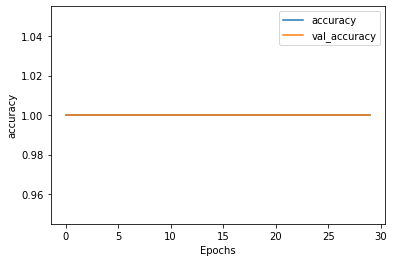

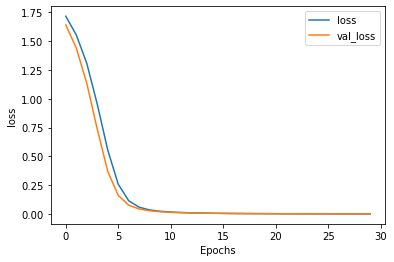

In [107]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [118]:
#visualizing embedded words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [120]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(1000, 16)


In [121]:
import io
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

#use tensorflow embedding projector to visualize results by uploading this vector and metadata

### TEST 

In [253]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [254]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    

X = data['tweet']
y = data['class'] 


categories = ["NotSexist", "Sexist"]

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

X = list(X)
y = [categories[i] for i in y]
X_train = list(X_train)
X_test = list(X_test)
y_train = [categories[i] for i in y_train]
y_test = [categories[i] for i in y_test]
print(y_train)

['NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'Sexist', 'Sexist', 'Sexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'Sexist', 'Sexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'Sexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'Sexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'Sexist', 'Sexist', 'NotSexist', 'Sexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', 'NotSexist', '

In [255]:
#tokenizing sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [256]:
word_index = tokenizer.word_index
total_words = len(word_index)+1 #1 for oov word
print(total_words)
print(word_index)

10744
{'<OOV>': 1, 'de': 2, 'pour': 3, 'balancetonporc': 4, 'pas': 5, 'du': 6, 'qui': 7, 'femme': 8, 'est': 9, 'dans': 10, 'sur': 11, 'sexisme': 12, 'ce': 13, 'au': 14, 'avec': 15, 'cest': 16, 'ne': 17, 'moiaussi': 18, 'on': 19, 'il': 20, 'femmes': 21, 'par': 22, 'plus': 23, 'vous': 24, 'mais': 25, 'ça': 26, 'contre': 27, 'metoo': 28, 'fait': 29, 'comme': 30, '»': 31, '«': 32, 'nous': 33, 'sexiste': 34, 'sont': 35, 'merkel': 36, 'ou': 37, 'si': 38, 'cette': 39, 'faire': 40, 'elle': 41, 'aux': 42, 'via': 43, 'tout': 44, 'angela': 45, 'bien': 46, 'viol': 47, 'suis': 48, 'aussi': 49, 'même': 50, 'monde': 51, 'mouvement': 52, 'ironie': 53, 'après': 54, 'ensemblecontrelesexisme': 55, 'ont': 56, 'c’est': 57, 'quand': 58, 'me': 59, 'y': 60, 'leur': 61, 'être': 62, 'hommes': 63, 'harcèlement': 64, 'france': 65, 'homme': 66, 'etmaintenant': 67, 'bleues': 68, 'royal': 69, 'merci': 70, 'journée': 71, 'travail': 72, 'dit': 73, 'tous': 74, 'macron': 75, 'pourquoi': 76, 'moi': 77, 'été': 78, 'non': 

In [257]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(X_test)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)


In [258]:
#tokenizing labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_train))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(y_test))



In [259]:
#creating model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 120, 16)           16000     
                                                                 
 global_average_pooling1d_9   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_18 (Dense)            (None, 24)                408       
                                                                 
 dense_19 (Dense)            (None, 6)                 150       
                                                                 
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [260]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq), 
                    verbose=2)

Epoch 1/30
69/69 - 6s - loss: 1.5923 - accuracy: 0.6918 - val_loss: 1.3195 - val_accuracy: 0.6688 - 6s/epoch - 81ms/step
Epoch 2/30
69/69 - 0s - loss: 0.9739 - accuracy: 0.6931 - val_loss: 0.7556 - val_accuracy: 0.6688 - 314ms/epoch - 5ms/step
Epoch 3/30
69/69 - 0s - loss: 0.6777 - accuracy: 0.6931 - val_loss: 0.6674 - val_accuracy: 0.6688 - 301ms/epoch - 4ms/step
Epoch 4/30
69/69 - 0s - loss: 0.6359 - accuracy: 0.6931 - val_loss: 0.6504 - val_accuracy: 0.6688 - 308ms/epoch - 4ms/step
Epoch 5/30
69/69 - 0s - loss: 0.6238 - accuracy: 0.6931 - val_loss: 0.6421 - val_accuracy: 0.6688 - 320ms/epoch - 5ms/step
Epoch 6/30
69/69 - 0s - loss: 0.6191 - accuracy: 0.6931 - val_loss: 0.6401 - val_accuracy: 0.6688 - 300ms/epoch - 4ms/step
Epoch 7/30
69/69 - 0s - loss: 0.6155 - accuracy: 0.6931 - val_loss: 0.6352 - val_accuracy: 0.6688 - 296ms/epoch - 4ms/step
Epoch 8/30
69/69 - 0s - loss: 0.6129 - accuracy: 0.6931 - val_loss: 0.6348 - val_accuracy: 0.6688 - 281ms/epoch - 4ms/step
Epoch 9/30
69/69 -

In [261]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

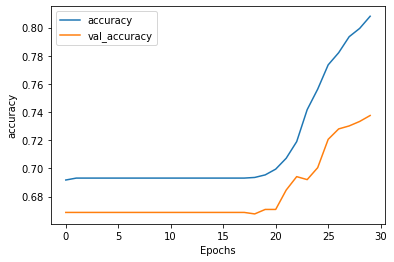

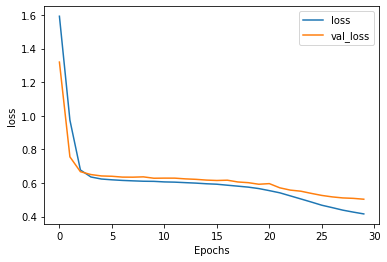

In [262]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [263]:
#visualizing embedded words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [264]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(1000, 16)


In [265]:
import io
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

#use tensorflow embedding projector to visualize results by uploading this vector and metadata